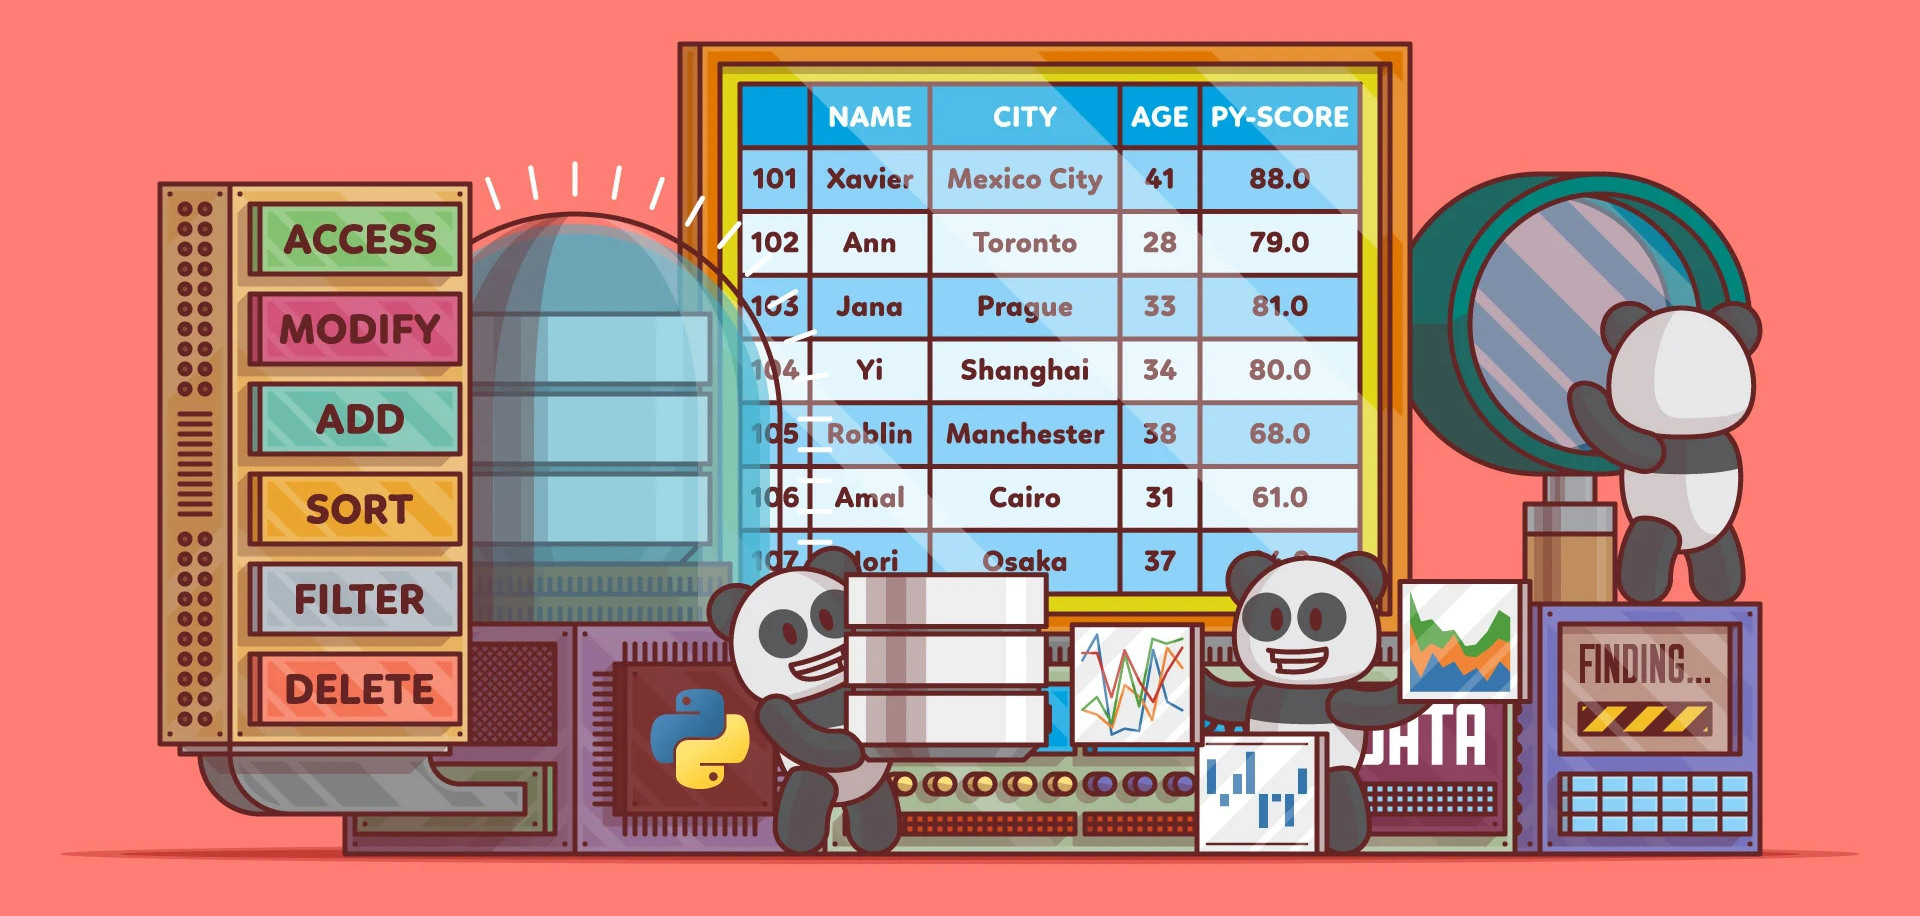

<a id="top" href="#bottom">跳至底部</a>

<br>
<div style="font-size:50px;text-align: center;font-weight: bold;">个人项目展现</div>
<br>
<br>
<div style="font-size: 23px;text-align: center;">by Python, Excel, SPSS and HTML</div>

<h1 style="float: left;">电影数据分析</h1> 
<a id="1" href="#2" style="float: right;">跳转至项目2</a>

**项目目标：**
- 分析“豆瓣电影top250排行榜”的效度
- 分析TOP排名与
- 分析
- 分析类型标签
- 分析概述呈现与短时记忆的关系

## 数据爬取与清洗

### 使用python批量获取网页数据并进行初步清洗：

In [1]:
import urllib.request,urllib.error 
from bs4 import BeautifulSoup 
import re 
import pandas as pd

In [7]:
def main(): # 流程控制
    baseurl="https://movie.douban.com/top250?start=" # 目标url的模板
    dataList=getData(baseurl)
    
    savepath="./source/top250.xlsx" # 采用相对路径保存
    saveData(dataList,savepath)

In [3]:
def askUrl(url):
    head={ 
        "User-Agent":"Mozilla / 5.0(Windows NT 10.0; WOW64) AppleWebKit / 537.36(KHTML, like  Gecko) Chrome / 86.0  .4240  .198  Safari / 537.36"
    } # 模拟浏览器头部，使用用户代理信息
    request=urllib.request.Request(url,headers=head) # 用Request封装url和header作为request对象
    
    html=""
    
    try: # 监控爬取异常
        response=urllib.request.urlopen(request) # 通过request对象返回response对象
        html=response.read().decode('utf-8') # 读取并解码
#         print(html)
    except Exception as result:
        if hasattr(result,'code'): 
            print(result.code) # 异常包含code项时返回相关信息
        if hasattr(result,'reason'):
            print(result.reason) # 异常包含reason项时返回相关信息
    return html

In [4]:
# 构建目标信息的正则表达式模板

# 详情链接：
findLink=re.compile(r'<a href="(.*?)">') 
# 海报链接：
findImg=re.compile(r'<img.*src="(.*?)"',re.S) # 无视换行符
# 片名：
findTitle=re.compile(r'<span class="title">(.*)</span>')
# 评分：
findRating=re.compile(r'<span class="rating_num" property="v:average">(.*)</span>')
# 评价人数：
findJudge=re.compile(r'<span>(\d*)人评价</span>')
# 概述：
findInq=re.compile(r'<span class="inq">(.*)</span>')
# 相关内容：
findBd=re.compile(r'<p class="">(.*?)</p>',re.S)

def getData(baseurl):
    
    dataList=[] # 用dataList保存全部信息
    
    for i in range(0,10): # 爬取10次/页
        url=baseurl+str(i*25) 
        html=askUrl(url) # 把获取到的网页源码保存到html变量
        
        # 解析数据:
        soup=BeautifulSoup(html,'html.parser')
        for item in soup.find_all('div',class_='item'): # 遍历一页内所有item类，每个item类包含一部电影的全部信息
            
#             print(item)
            data=[] # 用data保存各个信息
            item=str(item) # 防止错误：expected string or bytes-like object

            link=re.findall(findLink,item)[0] # 在item中根据正则表达式finLInk返回目标信息列表，提取link
            data.append(link) # 把link添加至data

            img=re.findall(findImg,item)[0]
            data.append(img)

            title=re.findall(findTitle,item) 
            if len(title)==2: # 既有中文名也有外文名
                ctitle=title[0] # 提取中文名
                data.append(ctitle)
                etitle=title[1].replace('/','')
                etitle=etitle.replace('\xa0','') # 去掉无关符号
                data.append(etitle)
            else: # 只有中文名
                data.append(title[0]) # 提取中文名
                data.append(' ') # 为保证生成表格的一致性，外文名处留空

            rating=re.findall(findRating,item)[0]
            data.append(rating)

            judge=re.findall(findJudge,item)[0]
            data.append(judge)

            inq=re.findall(findInq,item)
            if len(inq)!=0:
                inq=inq[0].replace('。','') # 去掉句号
                data.append(inq)
            else: # 概述缺失时留空
                data.append(' ')


            bd=re.findall(findBd,item)[0]
            bd=re.sub("<br(\s+)?/>(\s+)?","",bd) # 用正则替换保守地（0/1）去掉br标签内外的空白符
            bd=bd.strip() # 去掉前后空格
            bd=bd.replace('\xa0','')
            data.append(bd)

            dataList.append(data) # 把data放入datalist


#     print(dataList)
    return dataList

In [58]:
def saveData(dataList,savepath):
    dataList=pd.DataFrame(dataList,columns=['详情链接','海报链接','中文名','外文名','评分','评价人数','概述','相关内容'])
    dataList.insert(0,column='排名',value=range(1,251)) # 添加排名列
    dataList.to_excel(savepath,index=False)

In [59]:
if __name__ == '__main__':
    main()
    print('complete')

complete


**处理完成，效果如下：**
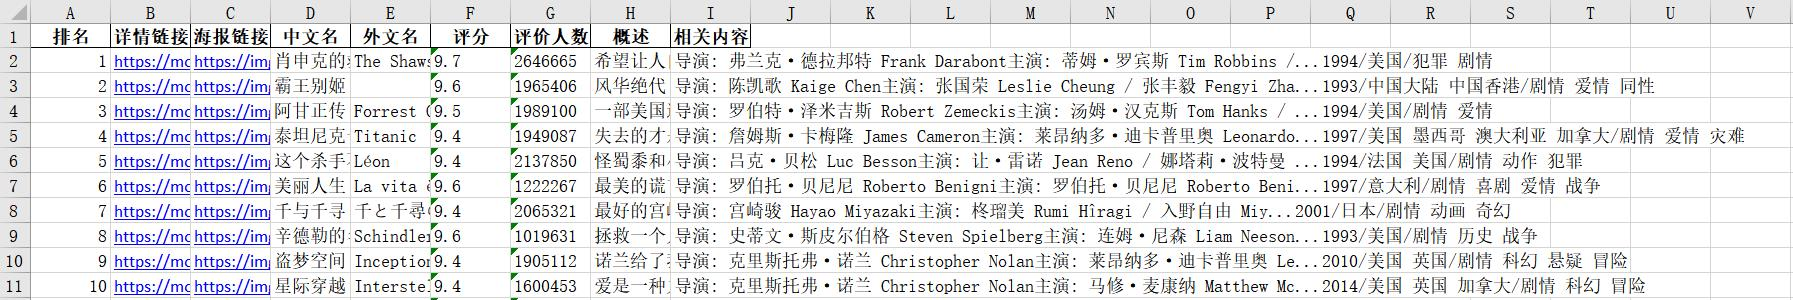

### 使用Excel对获取的数据作进一步处理：

**① 对电影别名的有无进行判断标注：**
- =IF(SUBSTITUTE(E2," ","")="",0,1)  
    
**② 对电影概述的有无进行判断标注，并分析概述内容所包含的信息组块数：**
- =IF(ISBLANK(I2),0,1)
- =LENB(ASC(I2))/2：
    - 标点符号也参与意义的构建，具有形式意义（但缺乏内容意义），因此每单位视为0.5个信息组块
    - 原数据为双字节的全角字符串，进行标点符号的全-半角转换后，总字节长度的二分之一即为信息组块数
    
**③ 对【相关内容】进行数据分离：**
- 分离出电影年份；
- 分离出电影所属国家或地区；
- 分离出电影类型标签，并根据豆瓣官方发布的全部类型标签进行判断标注：
    - =IF(ISNUMBER(FIND(Q$1,$P2)),1,0)

**处理完成，效果如下：** 
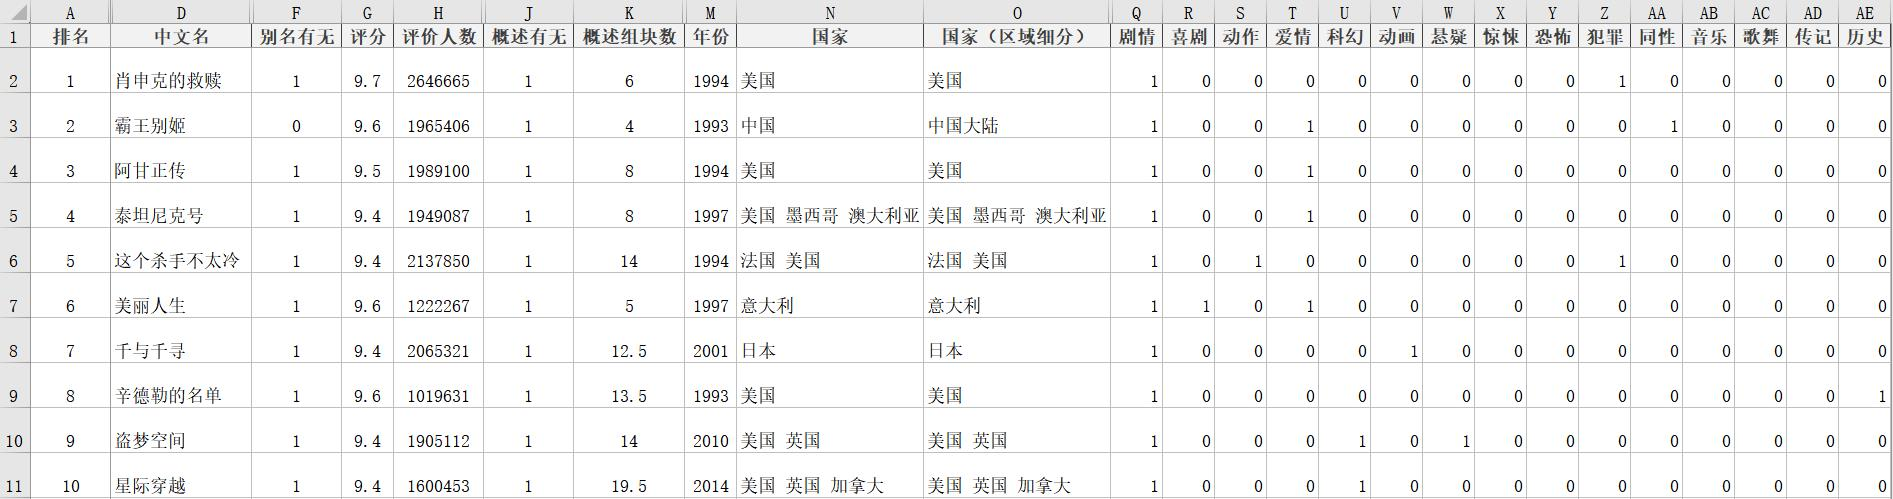

<h1 style="float: left;">标注项目数据分析</h1> 
<a id="2" href="#1" style="float: right;">跳转至项目1</a>

**项目目标：**
- 分析
- 制作自动化周报

<a id="bottom" href="#top">跳至顶部</a>

END